In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import matplotlib.font_manager

import datetime

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times New Roman"})

In [3]:
def jaccard_index(x):
    union = len(x[0] | x[1])
    intersection = len(x[0] & x[1])
    
    return intersection / union

In [4]:
def yearly_comparison(df, year_1, year_2, min_cnts=5, r_min_cnts=1, max_cnts=None):
    
    cnts_1 = df[df['year']==year_1]
    cnts_2 = df[df['year']==year_2]

    buyers = set(cnts_1.ubuyer.unique()) & set(cnts_2.ubuyer.unique())

    B1 = cnts_1[cnts_1.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S1").reset_index()
    B1 = B1.drop_duplicates(subset='ubuyer')
    B1['N1'] = B1['S1'].apply(len)
    B2 = cnts_2[cnts_2.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S2").reset_index()
    B2 = B2.drop_duplicates(subset='ubuyer')
    B2['N2'] = B2['S2'].apply(len)
    B = pd.merge(B1, B2, on='ubuyer', how='left')
    if max_cnts:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= min_cnts) & (B.N1 <= max_cnts) & (B.N2 <= max_cnts)]
    else:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= r_min_cnts)]
    B['jaccard'] = B[['S1', 'S2']].apply(jaccard_index, axis=1)

    return pd.merge(B, cri, how='left')

In [5]:
def yearly_comparison_supplier(df, year_1, year_2, lmin_cnts=5, rmin_cnts=0, lmax_cnts=np.inf, rmax_cnts=np.inf):
    
    cnts_1 = df[df['year']==year_1]
    cnts_2 = df[df['year']==year_2]
    
    suppliers = set(cnts_1.usupplier.unique()) & set(cnts_2.usupplier.unique())

    B1 = cnts_1[cnts_1.usupplier.isin(suppliers)].groupby('usupplier').ubuyer.apply(set).rename("S1").reset_index()
    B1 = B1.drop_duplicates(subset='usupplier')
    B1['N1'] = B1['S1'].apply(len)
    B2 = cnts_2[cnts_2.usupplier.isin(suppliers)].groupby('usupplier').ubuyer.apply(set).rename("S2").reset_index()
    B2 = B2.drop_duplicates(subset='usupplier')
    B2['N2'] = B2['S2'].apply(len)
    B = pd.merge(B1, B2, on='usupplier', how='left')
    B['N1'] = B.N1.fillna(0)
    B['N2'] = B.N2.fillna(0)
    B['S1'] = B.S1.fillna({i: set() for i in B.index})
    B['S2'] = B.S2.fillna({i: set() for i in B.index})
    B = B[(B.N1 >= lmin_cnts) & (B.N1 <= lmax_cnts) & (B.N2 >= rmin_cnts) & (B.N2 <= rmax_cnts)]


    B['jaccard'] = B[['S1', 'S2']].apply(jaccard_index, axis=1)

    return B

In [6]:
def yearly_corruption(df, year, min_cnts=5, max_cnts=None):
    
    chunk = df[df.year==year]
    N = chunk.groupby('ubuyer').size().rename('NC').reset_index()
    if max_cnts:
        buyers = N[(N.NC>=min_cnts) & (N.NC<=max_cnts)]['ubuyer'].unique()
    else:
        buyers = N[N.NC >= min_cnts]['ubuyer'].unique()
    B = chunk[chunk.ubuyer.isin(buyers)].groupby('ubuyer').CRI.mean().reset_index()

    return B

In [7]:
cnts = pd.read_csv("../data/pre-process/contratos_4.csv", parse_dates=['start_date'])

cnts['year'] = cnts.start_date.dt.year

cnts = cnts.dropna(subset=['usupplier', 'ubuyer'])

cnts_slevel = cnts[cnts.gvmnt_level=='S']

cnts = cnts[cnts.gvmnt_level=='F']

In [8]:
cri = cnts.groupby('ubuyer').CRI.mean().reset_index()

# Jaccard measure for consecutive years
    - All buyers
    - Small buyers
    - Big Buyers

# Volatile nodes in election years

## Federal 2018 election

In [84]:
B = yearly_comparison(cnts, 2018, 2019)

v_buyers = B[B.jaccard <= B.jaccard.quantile(.1)].ubuyer.unique()

In [109]:
np.savetxt('../data/network/volatile_buyers.txt', v_buyers, fmt='%s', delimiter='\n')

In [115]:
sup_2018 = cnts[cnts.year==2018].groupby('usupplier').size().rename('N').reset_index()

sup_2018 = set(sup_2018[sup_2018.N >= 1].usupplier.unique())

sup_2018 = sup_2018 - set(cnts[cnts.year==2019].usupplier.unique())

In [118]:
np.savetxt('../data/network/volatile_suppliers.txt', list(sup_2018), fmt='%s', delimiter='\n')

# Stable nodes in election years

## Federal 2018 election

In [9]:
B = yearly_comparison(cnts, 2018, 2019)

v_buyers = B[B.jaccard >= B.jaccard.quantile(.9)].ubuyer.unique()

In [10]:
np.savetxt('../data/network/stable_buyers.txt', v_buyers, fmt='%s', delimiter='\n')

## All buyers

In [73]:
data = []
years = sorted(cnts.year.unique())
for i in range(len(years) - 1):
    B = yearly_comparison(cnts, years[i], years[i+1])
    data.append([str(years[i]), B.jaccard.mean(), "All", B.CRI.mean()])
#    B = yearly_comparison(cnts, years[i], years[i+1], max_cnts=10)
#    data.append([str(years[i]), B.jaccard.mean(), "Tiny", B.CRI.mean()])
    B = yearly_comparison(cnts, years[i], years[i+1], min_cnts=5, max_cnts=30)
    data.append([str(years[i]), B.jaccard.mean(), r"Small $(5 \leq n \leq 30)$", B.CRI.mean()])
    B = yearly_comparison(cnts, years[i], years[i+1], min_cnts=31)
    data.append([str(years[i]), B.jaccard.mean(), r"Big $(30 < n)$", B.CRI.mean()])
#    B = yearly_comparison(cnts, years[i], years[i+1], min_cnts=100)
#    data.append([str(years[i]), B.jaccard.mean(), "Huge", B.CRI.mean()])

df = pd.DataFrame(data, columns=['Year', 'Persistence', 'Buyer size', 'CRV'])

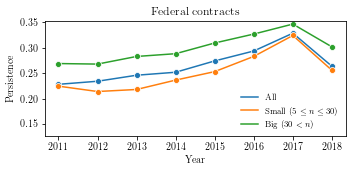

In [19]:
fig, ax = plt.subplots(figsize=(5, 2.5))

sns.lineplot(x='Year', y='Persistence', hue='Buyer size', data=df, marker="o", ax=ax)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=-0.1)
plt.legend(loc=4, prop={'size': "small"}, frameon=False)
ax.set_ylim((0.126563672887047, 0.3525237683484298))
ax.set_title('Federal contracts')
plt.tight_layout()

fig.savefig("../figures/persistence_federal.pdf")

In [20]:
data = []
years = sorted(cnts_slevel.year.unique())
for i in range(len(years) - 1):
    B = yearly_comparison(cnts_slevel, years[i], years[i+1])
    data.append([str(years[i]), B.jaccard.mean(), "All", B.CRI.mean()])
#    B = yearly_comparison(cnts_slevel, years[i], years[i+1], max_cnts_slevel=10)
#    data.append([str(years[i]), B.jaccard.mean(), "Tiny", B.CRI.mean()])
    B = yearly_comparison(cnts_slevel, years[i], years[i+1], min_cnts=5, max_cnts=30)
    data.append([str(years[i]), B.jaccard.mean(), r"Small $(5 \leq n \leq 30)$", B.CRI.mean()])
    B = yearly_comparison(cnts_slevel, years[i], years[i+1], min_cnts=31)
    data.append([str(years[i]), B.jaccard.mean(), r"Big $(30 < n)$", B.CRI.mean()])
#    B = yearly_comparison(cnts_slevel, years[i], years[i+1], min_cnts_slevel=100)
#    data.append([str(years[i]), B.jaccard.mean(), "Huge", B.CRI.mean()])

df_2 = pd.DataFrame(data, columns=['Year', 'Persistence', 'Buyer size', 'CRV'])

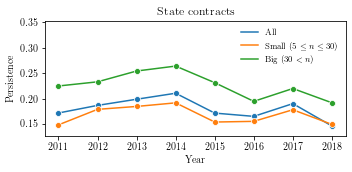

In [21]:
fig, ax = plt.subplots(figsize=(5, 2.5))

sns.lineplot(x='Year', y='Persistence', hue='Buyer size', data=df_2, marker="o", ax=ax)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=-0.1)
plt.legend(loc=1, prop={'size': "small"}, frameon=False)
ax.set_ylim((0.126563672887047, 0.3525237683484298))
ax.set_title('State contracts')

plt.tight_layout()
fig.savefig("../figures/persistence_local.pdf")

# Electoral change by State

In [119]:
electoral_years = {
    "AGU": 2016,
    "BCN": 2013,
    "BCS": 2015,
    "CAM": 2015,
    "CHP": 2018,
    "CHH": 2016,
    "CMX": 2018,
    "COA": 2017,
    "COL": 2016,
    "DUR": 2016,
    "GUA": 2018,
    "GRO": 2015,
    "HID": 2016,
    "JAL": 2018,
    "MEX": 2017,
    "MIC": 2015,
    "MOR": 2018,
    "NAY": 2017,
    "NLE": 2015,
    "OAX": 2016,
    "PUE": 2018,
    "QUE": 2015,
    "ROO": 2016,
    "SLP": 2015,
    "SIN": 2017,
    "SON": 2015,
    "TAB": 2018,
    "TAM": 2016,
    "TLA": 2016,
    "VER": 2018,
    "YUC": 2018,
    "ZAC": 2016}

In [120]:
df_ele = pd.DataFrame(electoral_years.items(), columns=['code', 'year'])

In [34]:
df_ele.shape

(32, 2)

In [32]:
df_ele.year.value_counts()

2016    10
2018     9
2015     8
2017     4
2013     1
Name: year, dtype: int64

In [121]:
data = []
years = sorted(cnts.year.unique())
for state in sorted(cnts.code_b.unique()):
    for i in range(len(years) - 1):
        if  electoral_years[state] == years[i]:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1])
            data.append([str(years[i]), B.jaccard.mean(), state, "red"])
        elif electoral_years[state] - 1 == years[i]:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1])
            data.append([str(years[i]), B.jaccard.mean(), state, "green"])
        else:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1])
            data.append([str(years[i]), B.jaccard.mean(), state, "blue"])

In [36]:
df_state = pd.DataFrame(data, columns=["Year", "Persistence", "State", "Electoral"])

In [37]:
df_state["Year"] = df_state["Year"].astype(str)

## State level Volatile buyers and suppliers

In [255]:
dfs = []
for state in electoral_years:
    y = electoral_years[state]
    B = yearly_comparison(cnts_slevel[cnts_slevel.code_b==state], y, y+1, min_cnts=4)
    B['year'] = y
    B['state'] = state
    dfs.append(B)

In [256]:
B = pd.concat(dfs)

In [257]:
B = B[B['N1'] >= 5]

In [271]:
v_buyers = B[B.jaccard <= B.jaccard.quantile(.1)][['state', 'year', 'ubuyer']]

In [274]:
v_buyers.to_csv('../data/network/state_volatile_buyers.csv', index=False)

In [242]:
data_3 = []
for code in electoral_years:
    y = electoral_years[code]
    sup_2018 = cnts_slevel[(cnts_slevel.year==y) & (cnts_slevel.code_b==code)].groupby('usupplier').size().rename('N').reset_index()
    sup_2018 = set(sup_2018.usupplier.unique())

    sup_2018 = sup_2018 - set(cnts_slevel[(cnts_slevel.year==y+1) & (cnts_slevel.code_b==code)].usupplier.unique())
    for v in sup_2018:
        data_3.append([code, y, v])

In [243]:
state_suppliers = pd.DataFrame(data_3, columns=['state', 'year', 'usupplier'])

In [246]:
state_suppliers.to_csv('../data/network/state_volatile_suppliers.csv', index=False)

## Federal level

In [69]:
df_state_gb = df_state.groupby(['State']).size().reset_index().drop(0, axis=1)

delta_p = (df_state[df_state.Electoral=='red'].sort_values(by="State").Persistence.values -
                       df_state[df_state.Electoral=='green'].sort_values(by="State").Persistence.values)

df_state_gb['delta'] = delta_p

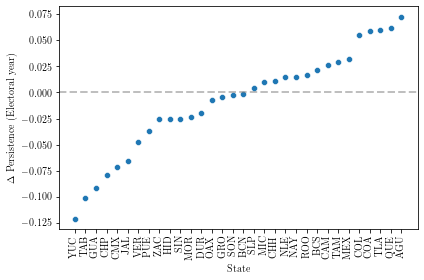

In [39]:
sns.scatterplot(x="State", y="delta", data=df_state_gb.sort_values(by="delta"))
plt.axhline(0, linestyle="--", color="gray", linewidth=2, alpha=.5)
plt.ylabel(r"$\Delta$ Persistence (Electoral year)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/federal_persistence_change.pdf")

## State level

In [40]:
data = []
years = sorted(cnts_slevel.year.unique())
for state in sorted(cnts_slevel.code_b.unique()):
    print(state)
    for i in range(len(years) - 1):
        if  electoral_years[state] == years[i]:
            B = yearly_comparison(cnts_slevel[cnts_slevel.code_b==state], years[i], years[i+1], min_cnts=1)
            data.append([str(years[i]), B.jaccard.mean(), state, "red"])
        elif electoral_years[state] - 1 == years[i]:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1])
            data.append([str(years[i]), B.jaccard.mean(), state, "green"])
        else:
            B = yearly_comparison(cnts_slevel[cnts_slevel.code_b==state], years[i], years[i+1], min_cnts=1)
            data.append([str(years[i]), B.jaccard.mean(), state, "blue"])

AGU
BCN
BCS
CAM
CHH
CHP
CMX
COA
COL
DUR
GRO
GUA
HID
JAL
MEX
MIC
MOR
NAY
NLE
OAX
PUE
QUE
ROO
SIN
SLP
SON
TAB
TAM
TLA
VER
YUC
ZAC


In [41]:
df_state_2 = pd.DataFrame(data, columns=["Year", "Persistence", "State", "Electoral"])

In [42]:
df_state_2["Year"] = df_state_2["Year"].astype(str)

In [43]:
df_state_2_gb = df_state_2.groupby(['State']).size().reset_index().drop(0, axis=1)
df_state_2_gb = df_state_2_gb.sort_values(by="State")

delta_p = (df_state_2[df_state_2.Electoral=='red'].sort_values(by="State").Persistence.values -
                       df_state_2[df_state_2.Electoral=='green'].sort_values(by="State").Persistence.values)

df_state_2_gb['delta'] = delta_p

In [44]:
df_state_gb['Contract'] = 'Federal'

In [45]:
df_state_2_gb['Contract'] = 'Local'

In [46]:
states = pd.concat([df_state_gb[['State', 'delta', 'Contract']], df_state_2_gb])

In [61]:
def election_2018(x):
    if electoral_years[x] == 2018:
        return 'Yes'
    else:
        return 'No'

In [62]:
states['2018 Election'] = states['State'].apply(election_2018)

In [68]:
states[states.election==False].groupby('Contract').mean()

,delta,election,Election
Contract,,,
Federal,0.016306,False,2015.695652
Local,-0.149641,False,2015.695652


In [66]:
states.groupby('Contract').delta.mean()

Contract
Federal   -0.008193
Local     -0.165006
Name: delta, dtype: float64

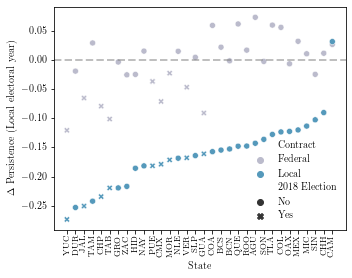

In [64]:
fig, ax = plt.subplots(figsize=(5, 4))
with sns.color_palette(["#bbbbcc", "#5599bb"]):
    sns.scatterplot(x="State", y="delta", hue="Contract",
                data=states.sort_values(by="delta"), hue_order=['Federal', 'Local'], ax=ax,
                   style='2018 Election', style_order=['No', 'Yes'])
plt.axhline(0, linestyle="--", color="gray", linewidth=2, alpha=.5)
plt.legend(frameon=False)
plt.ylabel(r"$\Delta$ Persistence (Local electoral year)")
plt.xticks(rotation=90)
plt.tight_layout()
ax.tick_params(axis="x", labelsize='small')
plt.savefig("../figures/persistence_local_federal.pdf")

# Figure 3

# State Level

In [34]:
years = sorted(cnts_slevel.year.unique())
dfs_state = []
for state in sorted(cnts_slevel.code_b.unique()):
    dfs = []
    for i in range(len(years) - 1):
        if  electoral_years[state] == years[i]:
            B = yearly_comparison(cnts_slevel[cnts_slevel.code_b==state], years[i], years[i+1], min_cnts=1)[['ubuyer', 'jaccard']]
            B['Electoral'] = "Post"
            B['State'] = state
            dfs.append(B)
        elif electoral_years[state] - 1 == years[i]:
            B = yearly_comparison(cnts_slevel[cnts_slevel.code_b==state], years[i], years[i+1])[['ubuyer', 'jaccard']]
            B['Electoral'] = "Pre"
            B['State'] = state
            dfs.append(B)
    dfs_state.append(pd.concat(dfs))
df_3 = pd.concat(dfs_state)

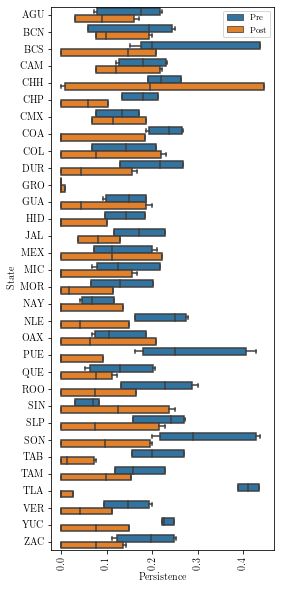

In [35]:
fig, ax = plt.subplots(figsize=(4, 10))
sns.boxplot(y="State", x="jaccard", hue="Electoral", data=df_3, ax=ax, showfliers=False, whis=.1)
plt.xlabel("Persistence")
plt.legend(loc=1, prop={'size': "small"})
plt.xticks(rotation=90)
plt.savefig("../figures/persistence_per_state_local.pdf");

# Federal level

In [36]:
years = sorted(cnts.year.unique())
dfs_state = []
for state in sorted(cnts.code_b.unique()):
    dfs = []
    for i in range(len(years) - 1):
        if  electoral_years[state] == years[i]:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1], min_cnts=1)[['ubuyer', 'jaccard']]
            B['Electoral'] = "Post"
            B['State'] = state
            dfs.append(B)
        elif electoral_years[state] - 1 == years[i]:
            B = yearly_comparison(cnts[cnts.code_b==state], years[i], years[i+1])[['ubuyer', 'jaccard']]
            B['Electoral'] = "Pre"
            B['State'] = state
            dfs.append(B)
    dfs_state.append(pd.concat(dfs))
df_4 = pd.concat(dfs_state)

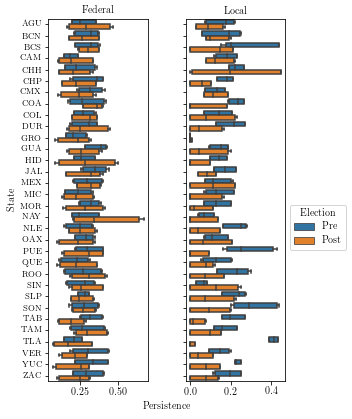

In [37]:
fig, ax = plt.subplots(1,2,figsize=(5, 6), sharey=True)
g = sns.boxplot(y="State", x="jaccard", hue="Electoral", data=df_4, ax=ax[0], showfliers=False, whis=.1)
ax[0].get_legend().remove()
ax[0].set_xlabel('')
ax[0].set_ylabel('State', fontsize=10)
ax[0].tick_params(axis="y", labelsize='small')
ax[0].text(0.5, 1.02,'Federal',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)
ax[0].text(0.475, 0.05,'Persistence',
     horizontalalignment='center',
     verticalalignment='center',
     transform = fig.transFigure)

# plt.legend(loc=1, prop={'size': "small"})
g_1 = sns.boxplot(y="State", x="jaccard", hue="Electoral", data=df_3, ax=ax[1], showfliers=False, whis=.1)
ax[1].legend(title="Election", bbox_to_anchor=(1, .5))
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].text(0.5, 1.02,'Local',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)
plt.tight_layout()
#plt.xticks(rotation=90)
plt.savefig("../figures/persistence_per_state_federal_and_local.pdf");

# Persistence change when a party changed and a party remained

In [38]:
electoral_years = {
    "AGU": True,
    "BCN": True,
    "BCS": False,
    "CAM": False,
    "CHP": True,
    "CHH": True,
    "CMX": True,
    "COA": False,
    "COL": False,
    "DUR": True,
    "GUA": False,
    "GRO": True,
    "HID": False,
    "JAL": True,
    "MEX": False,
    "MIC": True,
    "MOR": True,
    "NAY": True,
    "NLE": True,
    "OAX": True,
    "PUE": True,
    "QUE": True,
    "ROO": True,
    "SLP": False,
    "SIN": True,
    "SON": True,
    "TAB": True,
    "TAM": True,
    "TLA": False,
    "VER": True,
    "YUC": True,
    "ZAC": False}

In [39]:
df_ey = pd.DataFrame(electoral_years.items(), columns=['State', 'Party-change'])

In [40]:
df_3 = pd.merge(df_3, df_ey, how='left')

In [41]:
df_4 = pd.merge(df_4, df_ey, how='left')

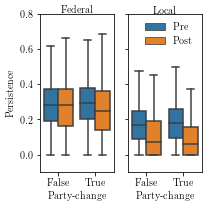

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(3,3), sharey=True)
sns.boxplot(x='Party-change', y='jaccard', hue='Electoral',  data=df_4, ax=ax[0], fliersize=0)
sns.boxplot(x='Party-change', y='jaccard', hue='Electoral',  data=df_3, ax=ax[1], fliersize=0)
ax[0].get_legend().remove()
ax[1].set_ylabel('')
ax[0].set_ylabel('Persistence')
ax[0].text(0.5, 1.02,'Federal',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)
ax[1].text(0.5, 1.021,'Local',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)
ax[0].set_ylim(-.1, .8)
plt.legend(loc=1, frameon=False)
plt.tight_layout()
fig.savefig("../figures/persistence_party_change.pdf")

# Persistence change in electoral years by type of service

Defense is kind of corrupted. We know that thanks to many late scandals. Let's see if we can target them be the number of desapeared companies from one year to the next.

In [45]:
ramos = cnts.groupby('desc_ramo').ramo.first().reset_index()

In [46]:
cnts = cnts.drop('ramo', axis=1)

In [47]:
cnts = pd.merge(cnts, ramos, how='left')

In [48]:
big_ramos = {
    'Instituto Mexicano del Seguro Social': 'Health',
    'Energía': 'Energy',
    'Bienestar': 'Social',
    'Salud': 'Health',
    'Comunicaciones y Transportes': 'T and C',
    'Hacienda y Crédito Público': 'Finance',
    'Agricultura y Desarrollo Rural': 'Rural',
    'Instituto de Seguridad y Servicios Sociales de los Trabajadores del Estado': 'Health',
    'Educación Pública': 'Education',
    'Medio Ambiente y Recursos Naturales': 'Environment',
    'Consejo Nacional de Ciencia y Tecnología': 'Science',
    'Cultura': 'Culture',
    'Marina': 'Defense',
    'Defensa Nacional': 'Defense',
    'Economía': 'Economy',
    'Gobernación': 'Home Affairs',
    'Turismo': 'Turism',
    'Entidades no Sectorizadas': 'Other',
    'Función Pública': 'Transparency',
    'Trabajo y Previsión Social': 'Social',
    'Desarrollo Agrario, Territorial y Urbano': 'T and C',
    'Procuraduría General de la República': 'Police',
    'Información Nacional Estadística y Geográfica': 'Demographics',
    'Relaciones Exteriores': 'Foreign Affairs',
    'Oficina de la Presidencia de la República': 'Presidency',
    'Comisión Federal de Competencia Económica': 'Economy',
    'Instituto Federal de Telecomunicaciones': 'T and C',
    'Tribunal Federal de Justicia Administrativa': 'Justice',
    'Tribunales Agrarios': 'Justice',
    'Comisión Reguladora de Energía': 'Energy', 
    'Consejería Jurídica del Ejecutivo Federal': 'Justice',
    'Inteligencia': 'Police',
    'Comisión Nacional de Hidrocarburos': 'Energy',
    'Instituto Nacional de Transparencia, Acceso a la Información y Protección de Datos Personales': 'Home Affairs',
    'Guardia Nacional': 'Police',
    'Seguridad': 'Police'
}

In [49]:
df_big_ramos = pd.DataFrame(big_ramos.items(), columns=['desc_ramo', 'type'])

cnts = pd.merge(cnts, df_big_ramos, how='left')

In [51]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times New Roman"})

## National defense

In [52]:
def prop_lost_companies(df, year_1, year_2, min_cnts=5, max_cnts=30):
    
    cnts_1 = df[df['year']==year_1]
    cnts_2 = df[df['year']==year_2]
    
    B_1 = cnts_1.groupby(['ubuyer', 'usupplier']).size().rename('N').reset_index()
    B_1 = B_1[(B_1.N >= min_cnts) & (B_1.N <= max_cnts)]
    supp_1 = set(B_1.usupplier.unique())
    supp_2 = set(cnts_2.usupplier.unique())
    if len(supp_1):
        return 1 - (len(supp_1 - supp_2) / len(supp_1))
    else:
        return np.nan

In [53]:
data = []
for i, y in enumerate(years[:-1]):
    for t in cnts.type.unique():
        p = prop_lost_companies(cnts[cnts.type==t], y, years[i+1])
        data.append([str(y), p, t])

In [54]:
df_t = pd.DataFrame(data, columns=['Year', 'Retention', 'Type'])

In [55]:
ramos = ['Health',
         'Energy',
         'Social',
         'T and C',
         'Finance',
         'Rural',
         'Education',
         'Environment',
         'Defense']

In [56]:
ramos = cnts.type.value_counts().index[:10]

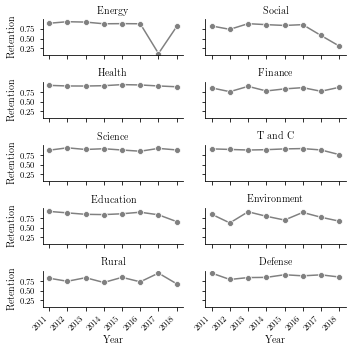

In [57]:
g = sns.FacetGrid(col='Type', col_wrap=2, data=df_t[df_t.Type.isin(ramos)], height=1, aspect=2.5)
g.map(sns.lineplot, 'Year', 'Retention', marker='o', color='gray')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for i in range(10):
    g.axes[i].tick_params(axis="both", labelsize="small")
    g.axes[i].set_xticklabels(g.axes[i].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
g.savefig('../figures/retention_per_type.pdf')

# Lower persitence suppliers

For the total number of suppliers, let's get the total number of days they were hired.

In [61]:
usupp = cnts.groupby('usupplier').size().rename('N').reset_index()

usupp = usupp[usupp.N >= 5]

nweeks = int((pd.Timestamp('2019-12-31') - pd.Timestamp('2011-01-01')).days / 30)

In [76]:
time_points = cnts[cnts.usupplier.isin(usupp.usupplier.unique())].groupby(
    'usupplier').start_date.apply(lambda x: sorted(list(x))).rename('window').reset_index()

time_points = dict(zip(time_points['usupplier'], time_points['window']))

In [133]:
M = np.zeros((len(time_points), nweeks + 1))

In [134]:
start = pd.Timestamp('2011-01-01')
for i, tp in enumerate(time_points):
    for t in time_points[tp]:
        j = int((t - start).days / 30)
        M[i][j] = 1

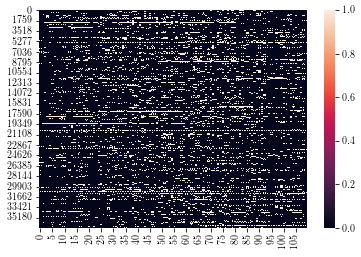

In [145]:
ax = sns.heatmap(M, vmin=0, vmax=1)
plt.savefig('../figures/monthly_distribution_suppliers.png', dpi=300)

## Clustering

In [136]:
d = sch.distance.pdist(M)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

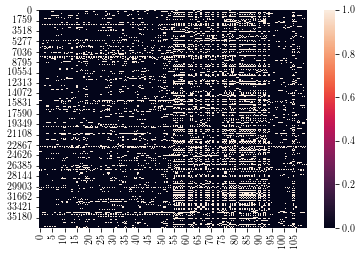

In [146]:
ax = sns.heatmap(M[ind], vmin=0, vmax=1)
plt.savefig("../figures/monthly_distribution_suppliers_cluster.png", dpi=300)